In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels
from statsmodels import regression

import sktime
import pmdarima

from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.ets import AutoETS
from sktime.utils.plotting import plot_series
from sktime.forecasting.base import ForecastingHorizon

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, Ridge
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

from statsmodels.tsa.api import ExponentialSmoothing

In [2]:
ufodb = pd.read_csv("scrubbed.csv")

/opt/anaconda3/envs/time/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (5,9) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
ufodb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80332 entries, 0 to 80331
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   datetime              80332 non-null  object 
 1   city                  80332 non-null  object 
 2   state                 74535 non-null  object 
 3   country               70662 non-null  object 
 4   shape                 78400 non-null  object 
 5   duration (seconds)    80332 non-null  object 
 6   duration (hours/min)  80332 non-null  object 
 7   comments              80317 non-null  object 
 8   date posted           80332 non-null  object 
 9   latitude              80332 non-null  object 
 10  longitude             80332 non-null  float64
dtypes: float64(1), object(10)
memory usage: 6.7+ MB


In [4]:
ufodb.dropna(inplace = True)

In [5]:
ufodb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66516 entries, 0 to 80331
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   datetime              66516 non-null  object 
 1   city                  66516 non-null  object 
 2   state                 66516 non-null  object 
 3   country               66516 non-null  object 
 4   shape                 66516 non-null  object 
 5   duration (seconds)    66516 non-null  object 
 6   duration (hours/min)  66516 non-null  object 
 7   comments              66516 non-null  object 
 8   date posted           66516 non-null  object 
 9   latitude              66516 non-null  object 
 10  longitude             66516 non-null  float64
dtypes: float64(1), object(10)
memory usage: 6.1+ MB


In [6]:
ufodb['country'].value_counts(normalize = True)

us    0.955454
ca    0.044230
gb    0.000165
au    0.000150
Name: country, dtype: float64

In [7]:
ufodb = ufodb[ufodb["country"] == "us"]
ufodb

,datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude
0,10/10/1949 20:30,san marcos,tx,us,cylinder,2700,45 minutes,This event took place in early fall around 194...,4/27/2004,29.8830556,-97.941111
3,10/10/1956 21:00,edna,tx,us,circle,20,1/2 hour,My older brother and twin sister were leaving ...,1/17/2004,28.9783333,-96.645833
4,10/10/1960 20:00,kaneohe,hi,us,light,900,15 minutes,AS a Marine 1st Lt. flying an FJ4B fighter/att...,1/22/2004,21.4180556,-157.803611
5,10/10/1961 19:00,bristol,tn,us,sphere,300,5 minutes,My father is now 89 my brother 52 the girl wit...,4/27/2007,36.5950000,-82.188889
7,10/10/1965 23:45,norwalk,ct,us,disk,1200,20 minutes,A bright orange color changing to reddish colo...,10/2/1999,41.1175000,-73.408333
...,...,...,...,...,...,...,...,...,...,...,...
80327,9/9/2013 21:15,nashville,tn,us,light,600.0,10 minutes,Round from the distance/slowly changing colors...,9/30/2013,36.165833,-86.784444
80328,9/9/2013 22:00,boise,id,us,circle,1200.0,20 minutes,Boise&#44 ID&#44 spherical&#44 20 min&#44 10 r...,9/30/2013,43.613611,-116.202500
80329,9/9/2013 22:00,napa,ca,us,other,1200.0,hour,Napa UFO&#44,9/30/2013,38.297222,-122.284444
80330,9/9/2013 22:20,vienna,va,us,circle,5.0,5 seconds,Saw a five gold lit cicular craft moving fastl...,9/30/2013,38.901111,-77.265556


In [8]:
def grep_year(x):
    x = x.split(" ")[0]
    x = x.split("/")[2]
    x = int(x)
    return x

ufodb["sightYear"] = ufodb["datetime"].apply(grep_year)
ufodb["reportYear"] = ufodb["date posted"].apply(grep_year)
ufodb.head()

,datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude,sightYear,reportYear
0,10/10/1949 20:30,san marcos,tx,us,cylinder,2700,45 minutes,This event took place in early fall around 194...,4/27/2004,29.8830556,-97.941111,1949,2004
3,10/10/1956 21:00,edna,tx,us,circle,20,1/2 hour,My older brother and twin sister were leaving ...,1/17/2004,28.9783333,-96.645833,1956,2004
4,10/10/1960 20:00,kaneohe,hi,us,light,900,15 minutes,AS a Marine 1st Lt. flying an FJ4B fighter/att...,1/22/2004,21.4180556,-157.803611,1960,2004
5,10/10/1961 19:00,bristol,tn,us,sphere,300,5 minutes,My father is now 89 my brother 52 the girl wit...,4/27/2007,36.5950000,-82.188889,1961,2007
7,10/10/1965 23:45,norwalk,ct,us,disk,1200,20 minutes,A bright orange color changing to reddish colo...,10/2/1999,41.1175000,-73.408333,1965,1999


In [9]:
states_us = ufodb[ufodb.country == "us"]["state"].value_counts().index
states_us = [i.upper() for i in states_us]
states_us

['CA',
 'FL',
 'WA',
 'TX',
 'NY',
 'IL',
 'AZ',
 'PA',
 'OH',
 'MI',
 'NC',
 'OR',
 'MO',
 'CO',
 'IN',
 'VA',
 'MA',
 'NJ',
 'GA',
 'WI',
 'TN',
 'MN',
 'SC',
 'CT',
 'KY',
 'MD',
 'NV',
 'OK',
 'NM',
 'IA',
 'AL',
 'UT',
 'KS',
 'AR',
 'LA',
 'ME',
 'ID',
 'NH',
 'MT',
 'WV',
 'NE',
 'MS',
 'AK',
 'HI',
 'VT',
 'RI',
 'SD',
 'WY',
 'DE',
 'ND',
 'PR',
 'DC']

In [10]:
states_ratio = ufodb[ufodb.country == "us"]["state"].value_counts().values
states_ratio

array([8683, 3754, 3707, 3398, 2915, 2447, 2362, 2319, 2251, 1781, 1722,
       1667, 1431, 1385, 1268, 1248, 1238, 1236, 1235, 1205, 1091,  996,
        986,  865,  843,  818,  778,  714,  693,  669,  629,  611,  599,
        578,  547,  544,  508,  482,  460,  438,  373,  368,  311,  257,
        254,  224,  177,  169,  165,  123,   24,    7])

/opt/anaconda3/envs/time/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


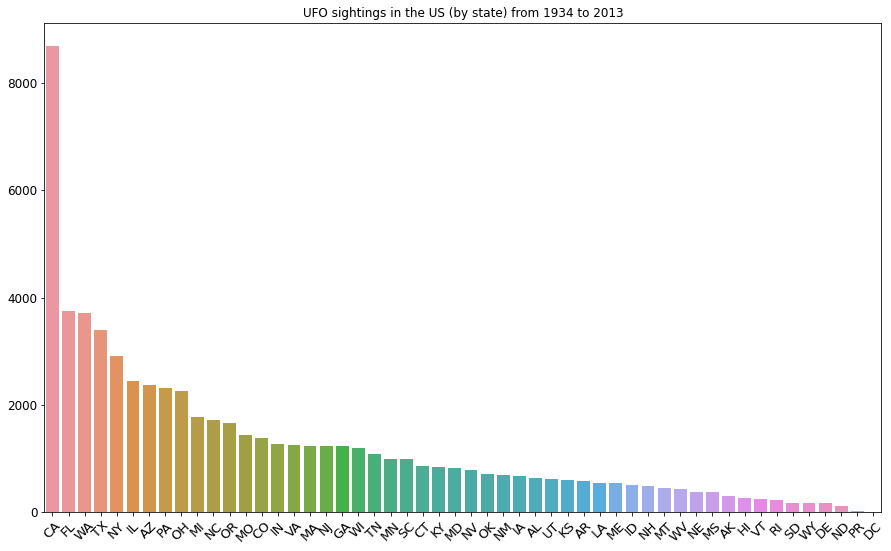

In [11]:
plt.subplots(figsize=(15,9))
sns.barplot(states_us, states_ratio)
plt.xticks(rotation=45, fontsize=13)
plt.yticks(fontsize=12)
plt.title('UFO sightings in the US (by state) from 1934 to 2013')
plt.show();

In [12]:
ufodb.head()

,datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude,sightYear,reportYear
0,10/10/1949 20:30,san marcos,tx,us,cylinder,2700,45 minutes,This event took place in early fall around 194...,4/27/2004,29.8830556,-97.941111,1949,2004
3,10/10/1956 21:00,edna,tx,us,circle,20,1/2 hour,My older brother and twin sister were leaving ...,1/17/2004,28.9783333,-96.645833,1956,2004
4,10/10/1960 20:00,kaneohe,hi,us,light,900,15 minutes,AS a Marine 1st Lt. flying an FJ4B fighter/att...,1/22/2004,21.4180556,-157.803611,1960,2004
5,10/10/1961 19:00,bristol,tn,us,sphere,300,5 minutes,My father is now 89 my brother 52 the girl wit...,4/27/2007,36.5950000,-82.188889,1961,2007
7,10/10/1965 23:45,norwalk,ct,us,disk,1200,20 minutes,A bright orange color changing to reddish colo...,10/2/1999,41.1175000,-73.408333,1965,1999


In [13]:
ufodb['comments']

0        This event took place in early fall around 194...
3        My older brother and twin sister were leaving ...
4        AS a Marine 1st Lt. flying an FJ4B fighter/att...
5        My father is now 89 my brother 52 the girl wit...
7        A bright orange color changing to reddish colo...
                               ...                        
80327    Round from the distance/slowly changing colors...
80328    Boise&#44 ID&#44 spherical&#44 20 min&#44 10 r...
80329                                         Napa UFO&#44
80330    Saw a five gold lit cicular craft moving fastl...
80331    2 witnesses 2  miles apart&#44 Red &amp; White...
Name: comments, Length: 63553, dtype: object

In [14]:
ufodb['sightYear'].value_counts().sort_values()

1934       1
1941       1
1929       1
1925       1
1920       1
        ... 
2009    3612
2008    3971
2011    4332
2013    5991
2012    6253
Name: sightYear, Length: 83, dtype: int64

In [15]:
# Creating a dataset where we look at just UFO sightings from 2000 and on.

ufo2k = ufodb[ufodb['sightYear'].isin(range(2000,2014))]

In [16]:
ufo2k.head()

,datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude,sightYear,reportYear
93,10/10/2000 03:00,perryville,mo,us,oval,180,3 minutes,The craft was big&#44 orange&#44 and oval shaped.,12/2/2000,37.7241667,-89.861111,2000,2000
94,10/10/2000 06:15,boynton beach,fl,us,other,10,10 seconds,Unusual light formation moving extremely fast ...,12/2/2000,26.5250000,-80.066667,2000,2000
98,10/10/2000 20:30,brinktown,mo,us,light,1800,30 min.,3 bright golden lights moving independently ab...,12/2/2000,38.1266667,-92.084444,2000,2000
99,10/10/2000 21:30,florence,ky,us,light,5,4-5 seconds,Two objects traveling side by side pass over&#...,12/2/2000,38.9988889,-84.626667,2000,2000
100,10/10/2000 21:30,seattle (west),wa,us,unknown,10,10 sec,Dark object in the shape of a (4) after dusk i...,2/11/2003,47.6063889,-122.330833,2000,2003


In [17]:
ufo2k.tail()

,datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude,sightYear,reportYear
80327,9/9/2013 21:15,nashville,tn,us,light,600.0,10 minutes,Round from the distance/slowly changing colors...,9/30/2013,36.165833,-86.784444,2013,2013
80328,9/9/2013 22:00,boise,id,us,circle,1200.0,20 minutes,Boise&#44 ID&#44 spherical&#44 20 min&#44 10 r...,9/30/2013,43.613611,-116.202500,2013,2013
80329,9/9/2013 22:00,napa,ca,us,other,1200.0,hour,Napa UFO&#44,9/30/2013,38.297222,-122.284444,2013,2013
80330,9/9/2013 22:20,vienna,va,us,circle,5.0,5 seconds,Saw a five gold lit cicular craft moving fastl...,9/30/2013,38.901111,-77.265556,2013,2013
80331,9/9/2013 23:00,edmond,ok,us,cigar,1020.0,17 minutes,2 witnesses 2 miles apart&#44 Red &amp; White...,9/30/2013,35.652778,-97.477778,2013,2013


In [18]:
ufo2k.reset_index(drop=True)

,datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude,sightYear,reportYear
0,10/10/2000 03:00,perryville,mo,us,oval,180,3 minutes,The craft was big&#44 orange&#44 and oval shaped.,12/2/2000,37.7241667,-89.861111,2000,2000
1,10/10/2000 06:15,boynton beach,fl,us,other,10,10 seconds,Unusual light formation moving extremely fast ...,12/2/2000,26.5250000,-80.066667,2000,2000
2,10/10/2000 20:30,brinktown,mo,us,light,1800,30 min.,3 bright golden lights moving independently ab...,12/2/2000,38.1266667,-92.084444,2000,2000
3,10/10/2000 21:30,florence,ky,us,light,5,4-5 seconds,Two objects traveling side by side pass over&#...,12/2/2000,38.9988889,-84.626667,2000,2000
4,10/10/2000 21:30,seattle (west),wa,us,unknown,10,10 sec,Dark object in the shape of a (4) after dusk i...,2/11/2003,47.6063889,-122.330833,2000,2003
...,...,...,...,...,...,...,...,...,...,...,...,...,...
50236,9/9/2013 21:15,nashville,tn,us,light,600.0,10 minutes,Round from the distance/slowly changing colors...,9/30/2013,36.165833,-86.784444,2013,2013
50237,9/9/2013 22:00,boise,id,us,circle,1200.0,20 minutes,Boise&#44 ID&#44 spherical&#44 20 min&#44 10 r...,9/30/2013,43.613611,-116.202500,2013,2013
50238,9/9/2013 22:00,napa,ca,us,other,1200.0,hour,Napa UFO&#44,9/30/2013,38.297222,-122.284444,2013,2013
50239,9/9/2013 22:20,vienna,va,us,circle,5.0,5 seconds,Saw a five gold lit cicular craft moving fastl...,9/30/2013,38.901111,-77.265556,2013,2013


In [19]:
ufo2k.shape

(50241, 13)

In [20]:
# Quick check to see how long our comments are:

ufo2k['tokenized data'] = [i for i in ufo2k['comments'].str.split()]

/var/folders/mh/dg46xljd4s3_y20ffr10z49c0000gn/T/ipykernel_62099/3581062023.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ufo2k['tokenized data'] = [i for i in ufo2k['comments'].str.split()]


In [21]:
ufo2k

,datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude,sightYear,reportYear,tokenized data
93,10/10/2000 03:00,perryville,mo,us,oval,180,3 minutes,The craft was big&#44 orange&#44 and oval shaped.,12/2/2000,37.7241667,-89.861111,2000,2000,"[The, craft, was, big&#44, orange&#44, and, ov..."
94,10/10/2000 06:15,boynton beach,fl,us,other,10,10 seconds,Unusual light formation moving extremely fast ...,12/2/2000,26.5250000,-80.066667,2000,2000,"[Unusual, light, formation, moving, extremely,..."
98,10/10/2000 20:30,brinktown,mo,us,light,1800,30 min.,3 bright golden lights moving independently ab...,12/2/2000,38.1266667,-92.084444,2000,2000,"[3, bright, golden, lights, moving, independen..."
99,10/10/2000 21:30,florence,ky,us,light,5,4-5 seconds,Two objects traveling side by side pass over&#...,12/2/2000,38.9988889,-84.626667,2000,2000,"[Two, objects, traveling, side, by, side, pass..."
100,10/10/2000 21:30,seattle (west),wa,us,unknown,10,10 sec,Dark object in the shape of a (4) after dusk i...,2/11/2003,47.6063889,-122.330833,2000,2003,"[Dark, object, in, the, shape, of, a, (4), aft..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80327,9/9/2013 21:15,nashville,tn,us,light,600.0,10 minutes,Round from the distance/slowly changing colors...,9/30/2013,36.165833,-86.784444,2013,2013,"[Round, from, the, distance/slowly, changing, ..."
80328,9/9/2013 22:00,boise,id,us,circle,1200.0,20 minutes,Boise&#44 ID&#44 spherical&#44 20 min&#44 10 r...,9/30/2013,43.613611,-116.202500,2013,2013,"[Boise&#44, ID&#44, spherical&#44, 20, min&#44..."
80329,9/9/2013 22:00,napa,ca,us,other,1200.0,hour,Napa UFO&#44,9/30/2013,38.297222,-122.284444,2013,2013,"[Napa, UFO&#44]"
80330,9/9/2013 22:20,vienna,va,us,circle,5.0,5 seconds,Saw a five gold lit cicular craft moving fastl...,9/30/2013,38.901111,-77.265556,2013,2013,"[Saw, a, five, gold, lit, cicular, craft, movi..."


In [22]:
comment_length = [len(tokens) for tokens in ufo2k['tokenized data']]

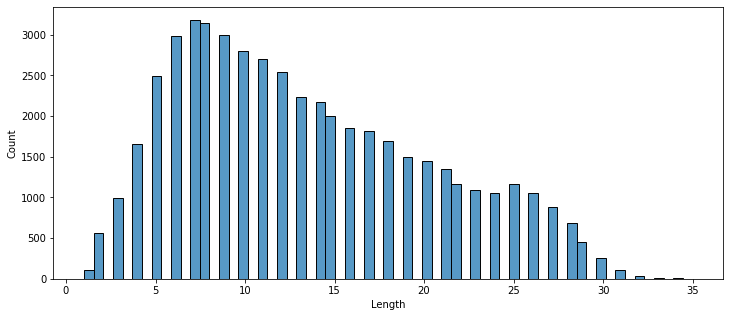

In [23]:
# Checking distribution!

plt.figure(figsize = (12, 5))
sns.histplot(comment_length)
plt.xlabel('Length')
plt.ylabel('Count');

In [24]:
# I wonder if there's any possiblity we can predict when the comment was made just by the length of the comment...? Or the words within the comments? 

X = ufo2k['comments']
y = ufo2k['sightYear']

In [25]:
# Normalize the dataset / stratify because this is a classification model.

y.value_counts(normalize = True)

2012    0.124460
2013    0.119245
2011    0.086224
2008    0.079039
2009    0.071893
2010    0.069804
2007    0.068569
2004    0.063733
2005    0.063534
2003    0.058040
2006    0.056906
2001    0.048029
2002    0.047750
2000    0.042774
Name: sightYear, dtype: float64

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y)

In [27]:
vect = CountVectorizer(lowercase = True, stop_words = 'english')

In [28]:
X_train_cv = vect.fit_transform(X_train)

In [29]:
X_test_cv = vect.transform(X_test)

In [30]:
X_train_cv

<37680x17024 sparse matrix of type '<class 'numpy.int64'>'
	with 327479 stored elements in Compressed Sparse Row format>

In [31]:
X_train_cv.A

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [32]:
# Now that we've converted into a numpy array, let us use Multinomial Bayes to see if we can predict the year.

nb = MultinomialNB()

In [33]:
nb.fit(X_train_cv, y_train)

MultinomialNB()

In [34]:
# Now we evaluate: 

nb.score(X_test_cv, y_test)

0.17148316216861714

In [35]:
nb.score(X_train_cv, y_train)

0.37330148619957537

/opt/anaconda3/envs/time/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


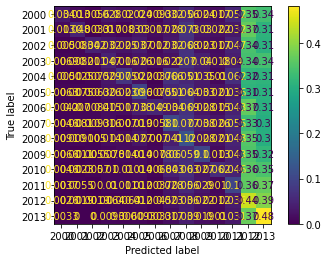

In [36]:
# Checking confusion matrix: 

from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(nb, 
                      X_test_cv,
                      y_test,
                      normalize = 'true');

In [37]:
y_train.value_counts(normalize = True)

2012    0.124469
2013    0.119241
2011    0.086226
2008    0.079034
2009    0.071895
2010    0.069798
2007    0.068577
2004    0.063721
2005    0.063535
2003    0.058041
2006    0.056900
2001    0.048036
2002    0.047744
2000    0.042781
Name: sightYear, dtype: float64

In [38]:
from sklearn.pipeline import make_pipeline
from sklearn import set_config

In [39]:
pipe = make_pipeline(CountVectorizer(lowercase = True, stop_words = 'english'), LogisticRegression(max_iter = 10_000))
set_config(display = 'diagram')

In [40]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('countvectorizer', CountVectorizer(stop_words='english')),
                ('logisticregression', LogisticRegression(max_iter=10000))])

In [41]:
pipe.score(X_test, y_test)

0.17920547727091793

In [42]:
pipe.score(X_train, y_train)

0.535323779193206

In [43]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

In [44]:
# It is overfitting by quite a lot. Logistic Regression is not the way to go. What about Decision Tree? 

pipe_d = make_pipeline(CountVectorizer(stop_words = 'english'), DecisionTreeClassifier())

In [45]:
pipe_d.get_params()

{'memory': None,
 'steps': [('countvectorizer', CountVectorizer(stop_words='english')),
  ('decisiontreeclassifier', DecisionTreeClassifier())],
 'verbose': False,
 'countvectorizer': CountVectorizer(stop_words='english'),
 'decisiontreeclassifier': DecisionTreeClassifier(),
 'countvectorizer__analyzer': 'word',
 'countvectorizer__binary': False,
 'countvectorizer__decode_error': 'strict',
 'countvectorizer__dtype': numpy.int64,
 'countvectorizer__encoding': 'utf-8',
 'countvectorizer__input': 'content',
 'countvectorizer__lowercase': True,
 'countvectorizer__max_df': 1.0,
 'countvectorizer__max_features': None,
 'countvectorizer__min_df': 1,
 'countvectorizer__ngram_range': (1, 1),
 'countvectorizer__preprocessor': None,
 'countvectorizer__stop_words': 'english',
 'countvectorizer__strip_accents': None,
 'countvectorizer__token_pattern': '(?u)\\b\\w\\w+\\b',
 'countvectorizer__tokenizer': None,
 'countvectorizer__vocabulary': None,
 'decisiontreeclassifier__ccp_alpha': 0.0,
 'decision

In [46]:
params = {
          'decisiontreeclassifier__max_depth': range(2, 6),
          'decisiontreeclassifier__min_samples_leaf': [2, 3, 4]
         } 

In [47]:
gs = GridSearchCV(estimator = pipe_d, param_grid = params, n_jobs = -1)

In [48]:
gs.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('countvectorizer',
                                        CountVectorizer(stop_words='english')),
                                       ('decisiontreeclassifier',
                                        DecisionTreeClassifier())]),
             n_jobs=-1,
             param_grid={'decisiontreeclassifier__max_depth': range(2, 6),
                         'decisiontreeclassifier__min_samples_leaf': [2, 3, 4]})

In [49]:
gs.score(X_test, y_test)

0.13653371546851364

In [50]:
from sklearn.metrics import balanced_accuracy_score

In [51]:
balanced_accuracy_score(y_test, gs.predict(X_test))

0.08118405299763298

In [52]:
from sklearn.tree import plot_tree

In [53]:
X_train

76473           Flying craft with orange flames underneath
28888          Bright&#44 white circular light.  No sound.
51748    Two star like lights&#44 one moving towards th...
16716    A ROUND GOLF BALL SHAPED THING WITH MULTIPLE T...
5532     Disc over my apt complex with a military plane...
                               ...                        
63862    While sitting in the backyard of home in a fai...
42505    05/15/03 24:30 Burlington&#44 W.V. Bright red ...
6284     Hoovering object w/flashing red&#44 blue&#44 a...
73923                Waterbury&#44 Middlebury Space Craft?
22334    Attempted abduction [?] of 2 people in Suburba...
Name: comments, Length: 37680, dtype: object

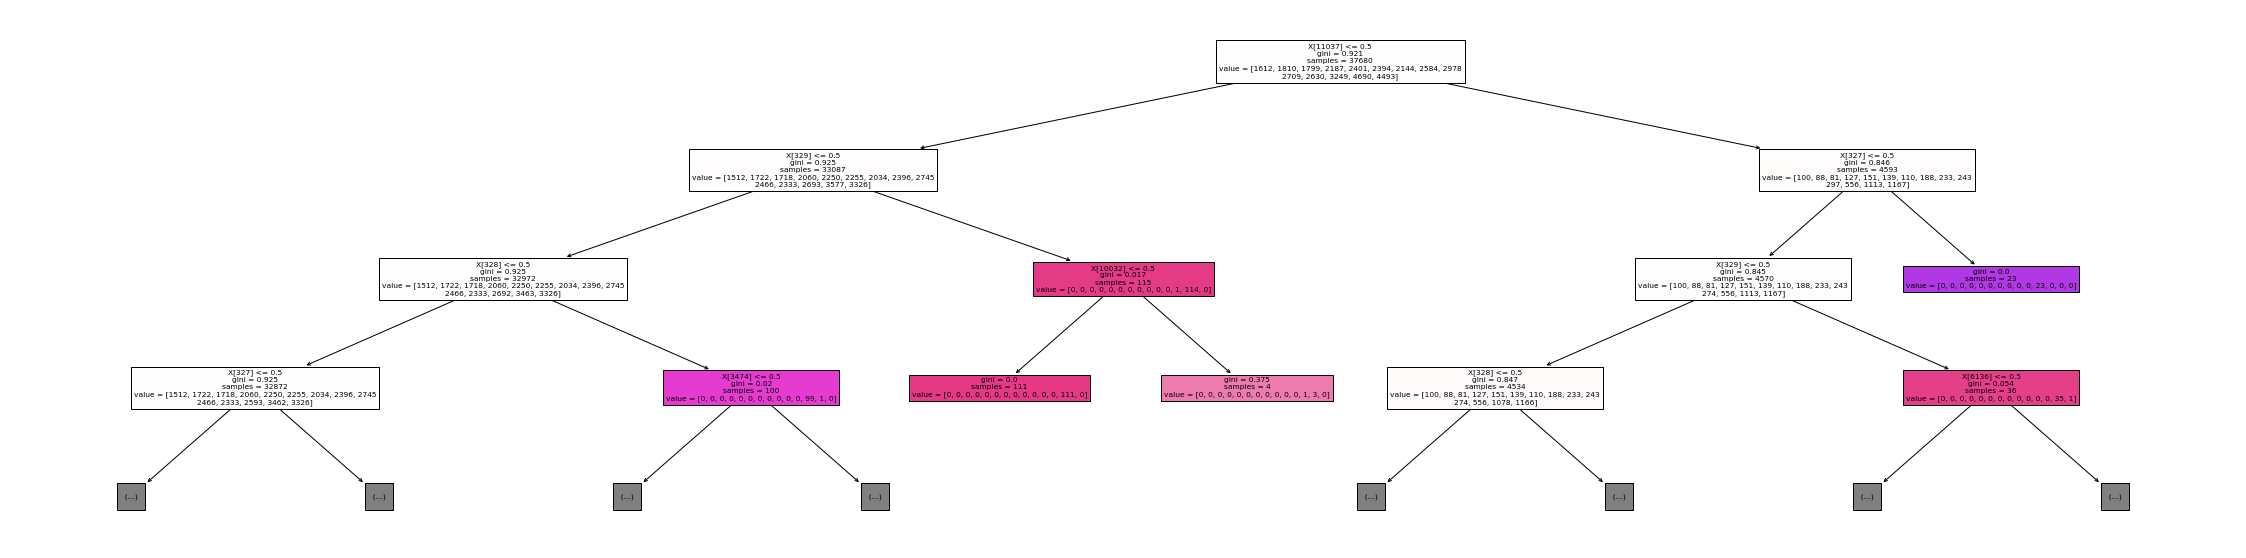

In [54]:
plt.figure(figsize=(40, 10))
plot_tree(gs.best_estimator_.named_steps['decisiontreeclassifier'], filled = True, max_depth = 3);

In [56]:
ufo2k.head(3)

,datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude,sightYear,reportYear,tokenized data
93,10/10/2000 03:00,perryville,mo,us,oval,180,3 minutes,The craft was big&#44 orange&#44 and oval shaped.,12/2/2000,37.7241667,-89.861111,2000,2000,"[The, craft, was, big&#44, orange&#44, and, ov..."
94,10/10/2000 06:15,boynton beach,fl,us,other,10,10 seconds,Unusual light formation moving extremely fast ...,12/2/2000,26.5250000,-80.066667,2000,2000,"[Unusual, light, formation, moving, extremely,..."
98,10/10/2000 20:30,brinktown,mo,us,light,1800,30 min.,3 bright golden lights moving independently ab...,12/2/2000,38.1266667,-92.084444,2000,2000,"[3, bright, golden, lights, moving, independen..."


In [ ]:
# What about in California...? 

ufo_ca_2k = ufodb[(ufodb['state'] == 'ca') & (ufodb['sightYear'].isin(range(2000,2014)))]

In [ ]:
ufo_ca_2k.reset_index(drop=True)
ufo_ca_2k

,datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude,sightYear,reportYear
105,10/10/2001 20:35,hayward,ca,us,circle,120,2/min.,FALLING STAR STOPS &#39SHOTS OUT DOZENS OF ...,11/20/2001,37.6688889,-122.079722,2001,2001
107,10/10/2001 21:30,fresno,ca,us,changing,900,15 min. apprx,Objects were sighted driving north on Highway ...,11/20/2001,36.7477778,-119.771389,2001,2001
118,10/10/2003 12:00,alhambra,ca,us,oval,300,5 min,3 Black ovals in the sky and a floating movie ...,1/17/2004,34.0952778,-118.126111,2003,2004
134,10/10/2004 15:00,berkeley,ca,us,unknown,180,3 minutes,While driving my car in the mid afternoon of a...,5/24/2005,37.8716667,-122.271667,2004,2005
146,10/10/2005 14:45,los angeles,ca,us,egg,10,10 seconds,Egg UFO over Hollywood Hills and LAX in LOS AN...,10/20/2005,34.0522222,-118.242778,2005,2005
...,...,...,...,...,...,...,...,...,...,...,...,...,...
80299,9/9/2012 20:00,arcata,ca,us,formation,600.0,10 minutes,Object with red and green lights moving sited ...,9/24/2012,40.866667,-124.081667,2012,2012
80305,9/9/2012 20:30,ventura,ca,us,chevron,900.0,15 minutes,Beautiful bright blue delta shaped aerobatics.,9/24/2012,34.278333,-119.292222,2012,2012
80310,9/9/2012 21:00,ventura,ca,us,circle,300.0,5 minutes,Bright Blue Object seen floating in sky near C...,9/24/2012,34.278333,-119.292222,2012,2012
80316,9/9/2013 09:51,san diego,ca,us,light,4.0,~4 seconds,2 white lights zig-zag over Qualcomm Stadium (...,9/30/2013,32.715278,-117.156389,2013,2013


In [64]:
# Okay, I think shape might be more interesting? 

ufo_ca_2k['shape'].value_counts(normalize = True)

light        0.221887
circle       0.100374
triangle     0.095628
fireball     0.081680
sphere       0.070175
other        0.067156
unknown      0.064999
disk         0.060253
oval         0.044722
formation    0.034656
changing     0.032499
cigar        0.019701
flash        0.017688
rectangle    0.016681
chevron      0.016681
diamond      0.015531
cylinder     0.014380
egg          0.009635
teardrop     0.008341
cross        0.003739
cone         0.003595
Name: shape, dtype: float64

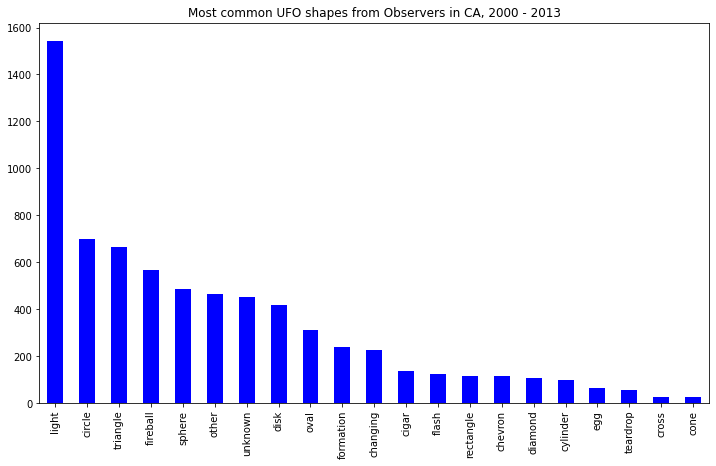

In [65]:
ufo_ca_2k['shape'].value_counts().plot(kind = 'bar',
                                      figsize = (12,7),
                                      title = 'Most common UFO shapes from Observers in CA, 2000 - 2013',
                                      color = 'blue');

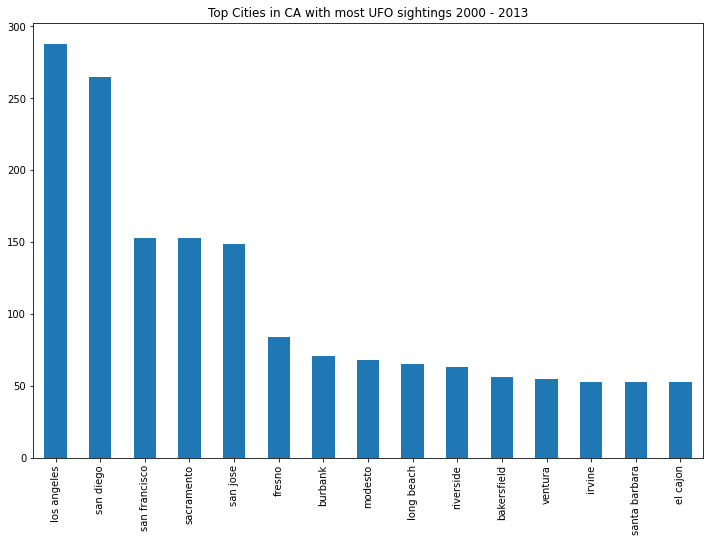

In [66]:
# What about cities in CA? Which cities had the most UFO sightings between 2000 and 2013?

ufo_ca_2k['city'].value_counts()[0:15].plot(kind = 'bar', 
                                           figsize = (12,8),
                                           title = 'Top Cities in CA with most UFO sightings 2000 - 2013');

In [67]:
# LA has the highest pop density, so it may be because of that we have highest sightings. What happens if we look at sightings per pop? 
# We should look at a single year so that population makes sense -- grabbing census data for these cities.

CA_2010_pop = pd.DataFrame(columns = ['population'])

In [68]:
ufo_ca_2010 = ufo_ca_2k[ufo_ca_2k['sightYear'] == 2010]

In [69]:
CA_2010_pop['count'] = ufo_ca_2010['city'].value_counts()[0:15].sort_values(ascending = True)

In [70]:
CA_2010_pop

,population,count
escondido,NaN,5
orange,NaN,5
lake elsinore,NaN,5
bakersfield,NaN,5
redding,NaN,5
riverside,NaN,5
long beach,NaN,6
oakland,NaN,6
thousand oaks,NaN,6
sacramento,NaN,8


In [71]:
CA_2010_pop.reset_index(inplace = True)

In [72]:
CA_2010_pop.rename(columns = {'index':'name'}, inplace=True)

In [73]:
ca_city = pd.read_csv('california_city.csv',thousands = ',')

In [74]:
ca_city.columns = ca_city.columns.str.lower().str.strip()

In [75]:
ca_city['name'] = ca_city['name'].str.lower()

In [76]:
ca_city.head()

,name,type,county,pop_2020,pop_2010
0,adelanto,City,San Bernardino,38046,31765
1,agoura hills,City,Los Angeles,20299,20330
2,alameda,City,Alameda,78280,73812
3,albany,City,Alameda,20271,18539
4,alhambra,City,Los Angeles,82868,83089


In [77]:
merged_ufo_ca = pd.merge(CA_2010_pop, ca_city, how = 'inner', on='name')

In [78]:
merged_ufo_ca.drop(columns='population',inplace=True)
merged_ufo_ca

,name,count,type,county,pop_2020,pop_2010
0,escondido,5,City,San Diego,151038,143911
1,orange,5,City,Orange,139911,134616
2,lake elsinore,5,City,Riverside,70265,51821
3,bakersfield,5,City,Kern,403455,347483
4,redding,5,City,Shasta,93611,89861
5,riverside,5,City,Riverside,314998,303871
6,long beach,6,City,Los Angeles,466742,462257
7,oakland,6,City,Alameda,440646,390724
8,thousand oaks,6,City,Ventura,126966,126683
9,sacramento,8,City,Sacramento,524943,466488


In [79]:
merged_ufo_ca.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15 entries, 0 to 14
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   name      15 non-null     object
 1   count     15 non-null     int64 
 2   type      15 non-null     object
 3   county    15 non-null     object
 4   pop_2020  15 non-null     int64 
 5   pop_2010  15 non-null     int64 
dtypes: int64(3), object(3)
memory usage: 840.0+ bytes


In [80]:
merged_ufo_ca['sightings per pop'] = merged_ufo_ca['count']/merged_ufo_ca['pop_2010']

In [81]:
merged_ufo_ca['% of pop'] = merged_ufo_ca['sightings per pop'] * 100

In [82]:
merged_ufo_ca.sort_values(by = 'sightings per pop', ascending = False)

,name,count,type,county,pop_2020,pop_2010,sightings per pop,% of pop
2,lake elsinore,5,City,Riverside,70265,51821,0.000096,0.009649
4,redding,5,City,Shasta,93611,89861,0.000056,0.005564
8,thousand oaks,6,City,Ventura,126966,126683,0.000047,0.004736
10,modesto,9,City,Stanislaus,218464,201165,0.000045,0.004474
1,orange,5,City,Orange,139911,134616,0.000037,0.003714
0,escondido,5,City,San Diego,151038,143911,0.000035,0.003474
9,sacramento,8,City,Sacramento,524943,466488,0.000017,0.001715
5,riverside,5,City,Riverside,314998,303871,0.000016,0.001645
7,oakland,6,City,Alameda,440646,390724,0.000015,0.001536
3,bakersfield,5,City,Kern,403455,347483,0.000014,0.001439


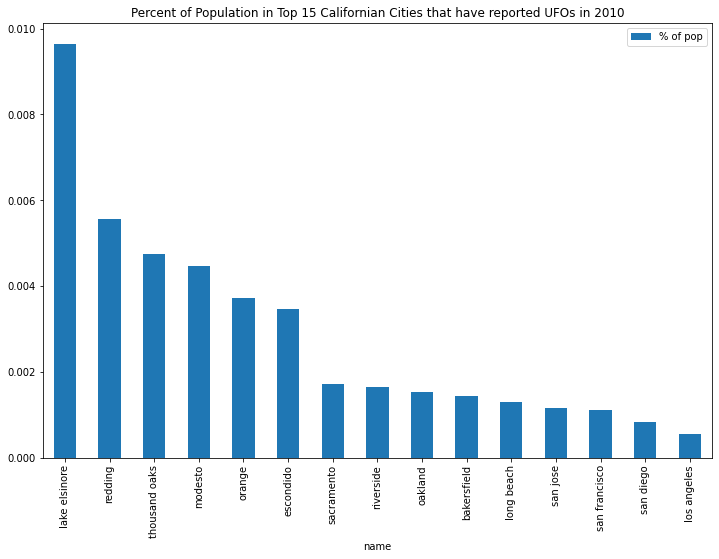

In [83]:
merged_ufo_ca.sort_values(by = '% of pop', ascending = False).plot(x = 'name',
                                                                   y = '% of pop',
                                                                   kind = 'bar',
                                                                   figsize = (12,8),
                                                                   title = 'Percent of Population in Top 15 Californian Cities that have reported UFOs in 2010');

In [84]:
# Did CA see a growth of sightings over the years? 

ufodb_ca = ufodb[ufodb['state'] == 'ca']

In [85]:
ufodb_ca['datetime'].str.split()

10       [10/10/1968, 13:00]
30       [10/10/1979, 22:00]
45       [10/10/1989, 00:00]
72       [10/10/1998, 02:30]
82       [10/10/1999, 00:01]
                ...         
80299      [9/9/2012, 20:00]
80305      [9/9/2012, 20:30]
80310      [9/9/2012, 21:00]
80316      [9/9/2013, 09:51]
80329      [9/9/2013, 22:00]
Name: datetime, Length: 8683, dtype: object

In [86]:
ufodb_ca = ufodb_ca[ufodb_ca['datetime'].str.contains('10/12/2013 24:00')==False]

In [87]:
ufodb_ca['datetime'].filter(like='24:00')

Series([], Name: datetime, dtype: object)

In [88]:
ufodb_ca.reset_index(drop = True, inplace=True)

In [89]:
ufodb_ca['datetime'] = pd.to_datetime(ufodb_ca['datetime'], errors='coerce')

In [90]:
ufodb_ca.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8682 entries, 0 to 8681
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   datetime              8620 non-null   datetime64[ns]
 1   city                  8682 non-null   object        
 2   state                 8682 non-null   object        
 3   country               8682 non-null   object        
 4   shape                 8682 non-null   object        
 5   duration (seconds)    8682 non-null   object        
 6   duration (hours/min)  8682 non-null   object        
 7   comments              8682 non-null   object        
 8   date posted           8682 non-null   object        
 9   latitude              8682 non-null   object        
 10  longitude             8682 non-null   float64       
 11  sightYear             8682 non-null   int64         
 12  reportYear            8682 non-null   int64         
dtypes: datetime64[ns](

In [91]:
ufodb_ca.sort_values(by = 'datetime', inplace = True)

In [92]:
ufodb_ca = ufodb_ca[pd.notnull(ufodb_ca['datetime'])]

In [93]:
ufodb_ca.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8620 entries, 7255 to 5311
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   datetime              8620 non-null   datetime64[ns]
 1   city                  8620 non-null   object        
 2   state                 8620 non-null   object        
 3   country               8620 non-null   object        
 4   shape                 8620 non-null   object        
 5   duration (seconds)    8620 non-null   object        
 6   duration (hours/min)  8620 non-null   object        
 7   comments              8620 non-null   object        
 8   date posted           8620 non-null   object        
 9   latitude              8620 non-null   object        
 10  longitude             8620 non-null   float64       
 11  sightYear             8620 non-null   int64         
 12  reportYear            8620 non-null   int64         
dtypes: datetime64[n

In [94]:
ufodb_ca.set_index('datetime', inplace = True)

In [95]:
ufodb_ca.head()

,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude,sightYear,reportYear
datetime,,,,,,,,,,,,
1937-08-15 21:00:00,fontana,ca,us,light,600.0,5 to 10 min,A cylinder light came on above us with no sound .,2/22/2002,34.092222,-117.434167,1937,2002
1944-01-01 12:00:00,san diego,ca,us,cigar,180,3 minutes,A sighting of one silver or white enlongated c...,7/25/2004,32.7152778,-117.156389,1944,2004
1945-08-08 12:00:00,huntington beach,ca,us,disk,300.0,5 minutes,MY DAD SAYS HIS AUNT AND UNCLE SAW THIS CRAFT ...,1/17/2004,33.660278,-117.998333,1945,2004
1946-02-01 17:00:00,merced,ca,us,sphere,10,10 seconds,Three luminescent chartreusse spheres moving &...,10/11/2005,37.3022222,-120.481944,1946,2005
1946-06-30 19:00:00,blairsden,ca,us,sphere,10,10 seconds,Looked up and saw sphere or disk 30-50 feet in...,1/21/2008,39.7811111,-120.615556,1946,2008


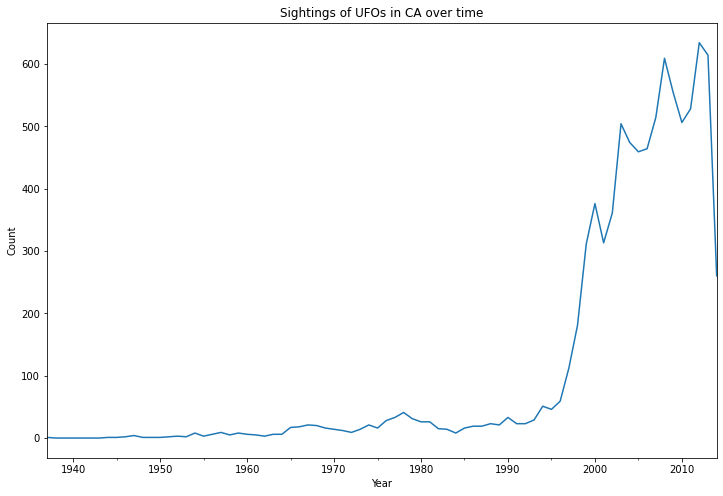

In [96]:
ufodb_ca['city'].resample('Y').count().plot(figsize = (12,8),
                                           title='Sightings of UFOs in CA over time',
                                           xlabel='Year',
                                           ylabel='Count');

In [97]:
ufodb['sightYear'].value_counts().sort_values()

1934       1
1941       1
1929       1
1925       1
1920       1
        ... 
2009    3612
2008    3971
2011    4332
2013    5991
2012    6253
Name: sightYear, Length: 83, dtype: int64

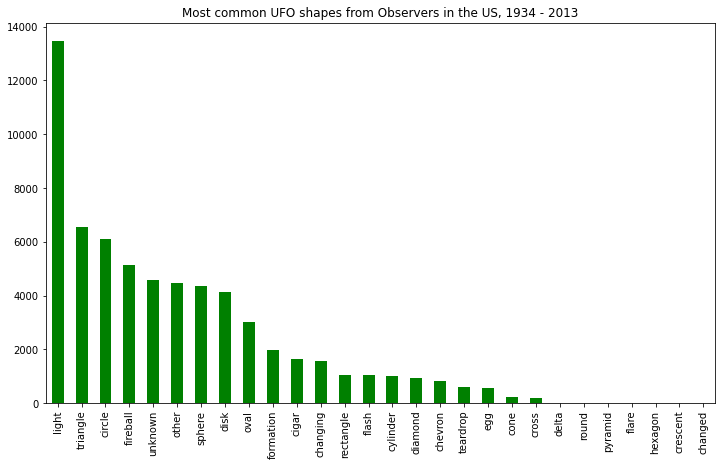

In [98]:
ufodb['shape'].value_counts().plot(kind = 'bar',
                                      figsize = (12,7),
                                      title = 'Most common UFO shapes from Observers in the US, 1934 - 2013',
                                      color = 'green');

#### Determine seasonality and predict UFO sightings going forward.

In [132]:
ufo2 = pd.read_csv("scrubbed.csv")

/opt/anaconda3/envs/time/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (5,9) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


##### need to move datetime into index so we can use this as a time series

In [100]:
ufo2.head()

,datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude
0,10/10/1949 20:30,san marcos,tx,us,cylinder,2700,45 minutes,This event took place in early fall around 194...,4/27/2004,29.8830556,-97.941111
1,10/10/1949 21:00,lackland afb,tx,NaN,light,7200,1-2 hrs,1949 Lackland AFB&#44 TX. Lights racing acros...,12/16/2005,29.38421,-98.581082
2,10/10/1955 17:00,chester (uk/england),NaN,gb,circle,20,20 seconds,Green/Orange circular disc over Chester&#44 En...,1/21/2008,53.2,-2.916667
3,10/10/1956 21:00,edna,tx,us,circle,20,1/2 hour,My older brother and twin sister were leaving ...,1/17/2004,28.9783333,-96.645833
4,10/10/1960 20:00,kaneohe,hi,us,light,900,15 minutes,AS a Marine 1st Lt. flying an FJ4B fighter/att...,1/22/2004,21.4180556,-157.803611


In [133]:
ufo2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80332 entries, 0 to 80331
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   datetime              80332 non-null  object 
 1   city                  80332 non-null  object 
 2   state                 74535 non-null  object 
 3   country               70662 non-null  object 
 4   shape                 78400 non-null  object 
 5   duration (seconds)    80332 non-null  object 
 6   duration (hours/min)  80332 non-null  object 
 7   comments              80317 non-null  object 
 8   date posted           80332 non-null  object 
 9   latitude              80332 non-null  object 
 10  longitude             80332 non-null  float64
dtypes: float64(1), object(10)
memory usage: 6.7+ MB


In [134]:
ufo2['datetime'] = pd.to_datetime(ufo2['datetime'], errors = 'coerce')

In [363]:
ufo_1990 = ufo2[ufo2['datetime'] >= '1/1/1990']

In [364]:
ufo_1990.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73478 entries, 48 to 80331
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   datetime              73478 non-null  datetime64[ns]
 1   city                  73478 non-null  object        
 2   state                 68249 non-null  object        
 3   country               64881 non-null  object        
 4   shape                 71694 non-null  object        
 5   duration (seconds)    73478 non-null  object        
 6   duration (hours/min)  73478 non-null  object        
 7   comments              73466 non-null  object        
 8   date posted           73478 non-null  object        
 9   latitude              73478 non-null  object        
 10  longitude             73478 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(9)
memory usage: 6.7+ MB


In [365]:
ufo_1990.head()

,datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude
48,1990-10-10 21:00:00,ashburn,ga,us,triangle,120,2 minutes,Translucent Craft that makes No Sound While Mo...,10/8/2007,31.7058333,-83.653333
49,1991-10-10 22:00:00,frisco,nc,us,unknown,1800,30 minutes,A friend and myself were standing on the shore...,1/28/1999,35.2350000,-75.628889
50,1991-10-10 22:00:00,harrisburg,pa,us,triangle,600,10 minutes,We observed 3 triangular shaped high speed obj...,5/9/2003,40.2736111,-76.884722
51,1992-10-10 17:00:00,panama city,fl,us,formation,3600,1 hour(?),During a road trip to Panama City a friend and...,1/28/1999,30.1586111,-85.660278
52,1992-10-10 18:00:00,stafford,tx,us,unknown,10,10 seconds,A man emerges from a beam of light that shines...,4/18/2012,29.6158333,-95.557500


In [366]:
ufo_1990.set_index('datetime', inplace=True)

In [367]:
ufo_1990.head()

,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude
datetime,,,,,,,,,,
1990-10-10 21:00:00,ashburn,ga,us,triangle,120,2 minutes,Translucent Craft that makes No Sound While Mo...,10/8/2007,31.7058333,-83.653333
1991-10-10 22:00:00,frisco,nc,us,unknown,1800,30 minutes,A friend and myself were standing on the shore...,1/28/1999,35.2350000,-75.628889
1991-10-10 22:00:00,harrisburg,pa,us,triangle,600,10 minutes,We observed 3 triangular shaped high speed obj...,5/9/2003,40.2736111,-76.884722
1992-10-10 17:00:00,panama city,fl,us,formation,3600,1 hour(?),During a road trip to Panama City a friend and...,1/28/1999,30.1586111,-85.660278
1992-10-10 18:00:00,stafford,tx,us,unknown,10,10 seconds,A man emerges from a beam of light that shines...,4/18/2012,29.6158333,-95.557500


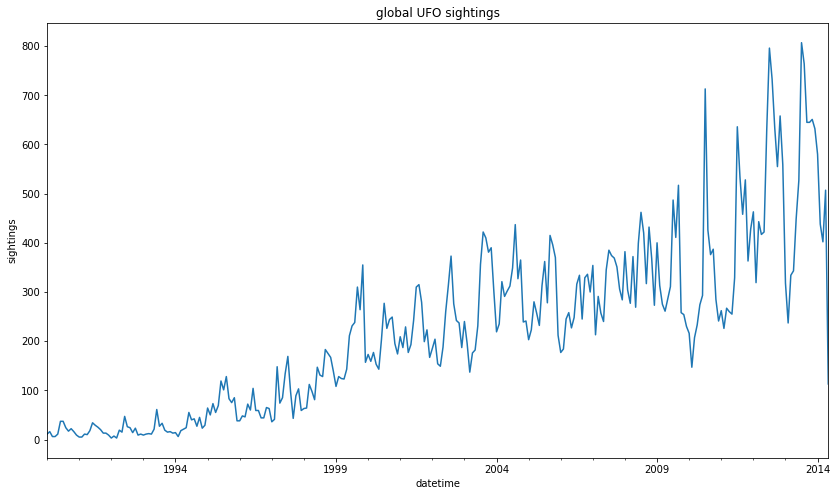

In [368]:
ufo_1990['country'].resample('M').count().plot(kind = 'line',
                                           ylabel = 'sightings',
                                           title = 'global UFO sightings',
                                           figsize = (14,8));

#### Let's work on predicting y!

In [399]:
y = ufo_1990['country'].resample('M').count()

In [423]:
y.dtype

dtype('int64')

### Train on old data, test on newer data! 

In [400]:
y_train, y_test = temporal_train_test_split(y, test_size = 40)

In [401]:
y_train

datetime
1990-01-31     11
1990-02-28     16
1990-03-31      6
1990-04-30      6
1990-05-31     11
             ... 
2010-09-30    376
2010-10-31    387
2010-11-30    285
2010-12-31    241
2011-01-31    262
Freq: M, Name: country, Length: 253, dtype: int64

In [402]:
y_test

datetime
2011-02-28    226
2011-03-31    267
2011-04-30    260
2011-05-31    255
2011-06-30    329
2011-07-31    636
2011-08-31    533
2011-09-30    458
2011-10-31    528
2011-11-30    363
2011-12-31    428
2012-01-31    463
2012-02-29    319
2012-03-31    443
2012-04-30    417
2012-05-31    422
2012-06-30    630
2012-07-31    796
2012-08-31    733
2012-09-30    633
2012-10-31    555
2012-11-30    658
2012-12-31    559
2013-01-31    318
2013-02-28    237
2013-03-31    334
2013-04-30    343
2013-05-31    449
2013-06-30    527
2013-07-31    807
2013-08-31    764
2013-09-30    645
2013-10-31    645
2013-11-30    651
2013-12-31    632
2014-01-31    580
2014-02-28    438
2014-03-31    402
2014-04-30    507
2014-05-31    113
Freq: M, Name: country, dtype: int64

### Plotting with sktime

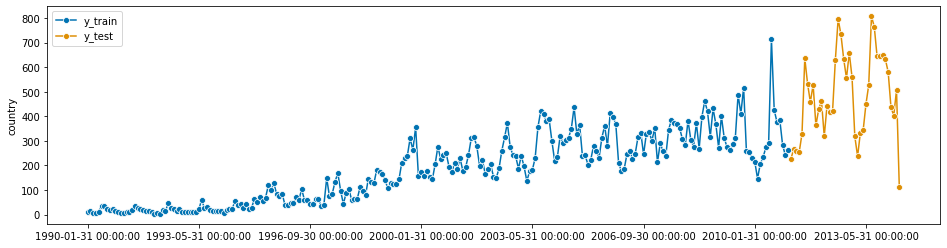

In [403]:
plot_series(y_train, y_test, labels = ['y_train','y_test']);

### Making a first prediction with NativeForecaster

In [404]:
naive_model_last = NaiveForecaster(strategy = 'last')
naive_model_last

NaiveForecaster()

In [405]:
y_train.tail(1)

datetime
2011-01-31    262
Freq: M, Name: country, dtype: int64

In [406]:
naive_model_last.fit(y_train)

NaiveForecaster()

In [407]:
y_last_preds = naive_model_last.predict(list(range(1,len(y_test)+1)))

/opt/anaconda3/envs/time/lib/python3.8/site-packages/sktime/utils/datetime.py:88: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  if not hasattr(x, "freq") or x.freq is None:
/opt/anaconda3/envs/time/lib/python3.8/site-packages/sktime/utils/datetime.py:90: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  by *= x.freq
/opt/anaconda3/envs/time/lib/python3.8/site-packages/sktime/utils/datetime.py:65: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  if hasattr(x, "freqstr"):
/opt/anaconda3/envs/time/lib/python3.8/site-packages/sktime/utils/datetime.py:66: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  return x.freqstr


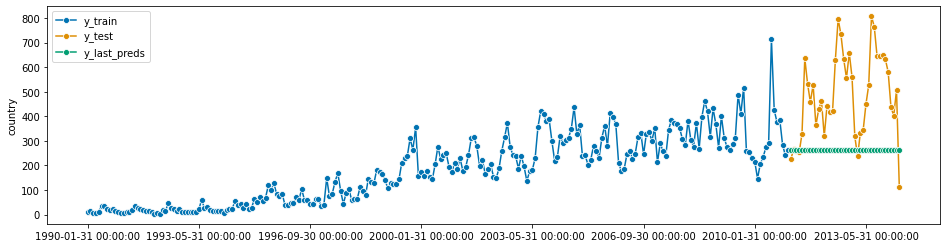

In [408]:
plot_series(y_train, y_test, y_last_preds, labels = ['y_train', 'y_test', 'y_last_preds']);

#### Score this.

In [409]:
from sklearn.metrics import mean_squared_error as mse

In [410]:
round(mse(y_test, y_last_preds, squared = False),0)

278.0

This tells us that the forecast is off by around 174 sightings.

### Time for a baseline mean forecast. 

In [411]:
naive_model_mean = NaiveForecaster(strategy = 'mean')
naive_model_mean.fit(y_train)

NaiveForecaster(strategy='mean')

In [412]:
y_mean_preds = naive_model_mean.predict(list(range(1,len(y_test)+1)))

/opt/anaconda3/envs/time/lib/python3.8/site-packages/sktime/utils/datetime.py:88: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  if not hasattr(x, "freq") or x.freq is None:
/opt/anaconda3/envs/time/lib/python3.8/site-packages/sktime/utils/datetime.py:90: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  by *= x.freq
/opt/anaconda3/envs/time/lib/python3.8/site-packages/sktime/utils/datetime.py:65: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  if hasattr(x, "freqstr"):
/opt/anaconda3/envs/time/lib/python3.8/site-packages/sktime/utils/datetime.py:66: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  return x.freqstr


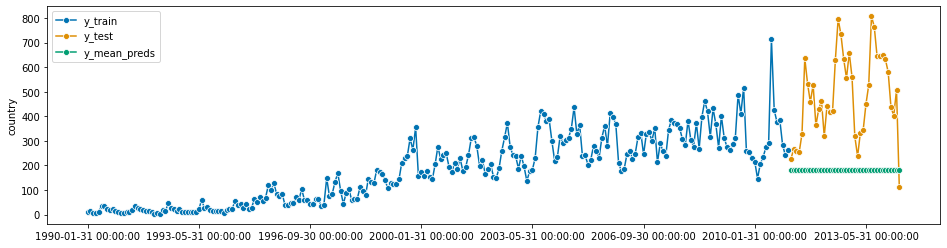

In [413]:
plot_series(y_train, y_test, y_mean_preds, labels = ['y_train', 'y_test', 'y_mean_preds']);

Checking for MSE:

In [414]:
round(mse(y_test, y_mean_preds, squared = False), 0)

346.0

Baseline null MSE score is way higher than what we had with our last prediction strategy.

#### Okay do we have any seasonality we can test?

In [415]:
naive_model_seasonal = NaiveForecaster(strategy = 'last', sp = 12)
naive_model_seasonal.fit(y_train)

NaiveForecaster(sp=12)

In [416]:
y_seasonal_preds = naive_model_seasonal.predict(list(range(1,len(y_test)+1)))

/opt/anaconda3/envs/time/lib/python3.8/site-packages/sktime/utils/datetime.py:88: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  if not hasattr(x, "freq") or x.freq is None:
/opt/anaconda3/envs/time/lib/python3.8/site-packages/sktime/utils/datetime.py:90: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  by *= x.freq
/opt/anaconda3/envs/time/lib/python3.8/site-packages/sktime/utils/datetime.py:65: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  if hasattr(x, "freqstr"):
/opt/anaconda3/envs/time/lib/python3.8/site-packages/sktime/utils/datetime.py:66: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  return x.freqstr


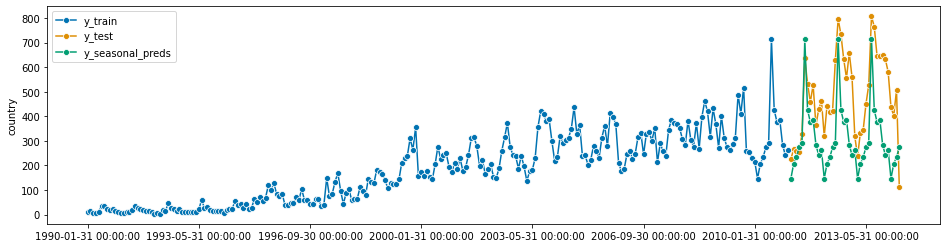

In [417]:
plot_series(y_train, y_test, y_seasonal_preds, labels = ['y_train', 'y_test', 'y_seasonal_preds']);

Checking MSE:

In [418]:
round(mse(y_test, y_seasonal_preds, squared = False),0)

214.0

Our last prediction performed better than the naive seasonal forecast...

### Time for ARIMA?

In [424]:
sarima_model = AutoARIMA(sp = 12, trace= True)

In [425]:
sarima_model.fit(y_train)

Performing stepwise search to minimize aic


/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=2691.222, Time=0.76 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2797.566, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=2749.967, Time=0.18 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=2758.242, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2795.631, Time=0.01 sec


/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'

 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=inf, Time=0.65 sec


/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=inf, Time=0.65 sec


/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=2693.270, Time=1.93 sec


/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=2693.682, Time=1.92 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=inf, Time=0.28 sec


/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'

 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=inf, Time=1.52 sec


/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=inf, Time=1.81 sec


/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,1,2)(2,0,2)[12] intercept   : AIC=2691.229, Time=1.98 sec


/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(1,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=0.78 sec
 ARIMA(2,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=0.76 sec


/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(3,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=0.81 sec


/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,1,3)(1,0,1)[12] intercept   : AIC=inf, Time=0.90 sec
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=0.55 sec


/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(1,1,3)(1,0,1)[12] intercept   : AIC=inf, Time=0.98 sec


/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(3,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=0.80 sec


/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(3,1,3)(1,0,1)[12] intercept   : AIC=inf, Time=1.15 sec
 ARIMA(2,1,2)(1,0,1)[12]             : AIC=2690.315, Time=0.34 sec


/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,1,2)(0,0,1)[12]             : AIC=2736.229, Time=0.35 sec


/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,1,2)(1,0,0)[12]             : AIC=2718.285, Time=0.36 sec


/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,1,2)(2,0,1)[12]             : AIC=2692.261, Time=1.43 sec


/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,1,2)(1,0,2)[12]             : AIC=2692.277, Time=1.49 sec
 ARIMA(2,1,2)(0,0,0)[12]             : AIC=2752.537, Time=0.18 sec


/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameter

 ARIMA(2,1,2)(0,0,2)[12]             : AIC=2711.567, Time=1.05 sec


/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,1,2)(2,0,0)[12]             : AIC=2693.566, Time=1.23 sec


/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'

 ARIMA(2,1,2)(2,0,2)[12]             : AIC=inf, Time=1.77 sec
 ARIMA(1,1,2)(1,0,1)[12]             : AIC=2689.626, Time=0.43 sec


/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(1,1,2)(0,0,1)[12]             : AIC=2735.022, Time=0.20 sec


/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(1,1,2)(1,0,0)[12]             : AIC=2717.162, Time=0.25 sec


/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(1,1,2)(2,0,1)[12]             : AIC=2691.610, Time=1.27 sec


/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(1,1,2)(1,0,2)[12]             : AIC=2691.614, Time=1.28 sec
 ARIMA(1,1,2)(0,0,0)[12]             : AIC=2752.432, Time=0.11 sec


/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameter

 ARIMA(1,1,2)(0,0,2)[12]             : AIC=2711.137, Time=0.84 sec


/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(1,1,2)(2,0,0)[12]             : AIC=2693.200, Time=0.73 sec


/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(1,1,2)(2,0,2)[12]             : AIC=2689.633, Time=1.76 sec
 ARIMA(0,1,2)(1,0,1)[12]             : AIC=2698.844, Time=0.21 sec
 ARIMA(1,1,1)(1,0,1)[12]             : AIC=2692.115, Time=0.32 sec
 ARIMA(1,1,3)(1,0,1)[12]             : AIC=2689.367, Time=0.53 sec
 ARIMA(1,1,3)(0,0,1)[12]             : AIC=2734.681, Time=0.28 sec
 ARIMA(1,1,3)(1,0,0)[12]             : AIC=2717.236, Time=0.26 sec
 ARIMA(1,1,3)(2,0,1)[12]             : AIC=2691.299, Time=1.17 sec
 ARIMA(1,1,3)(1,0,2)[12]             : AIC=2691.319, Time=1.72 sec
 ARIMA(1,1,3)(0,0,0)[12]             : AIC=2751.111, Time=0.10 sec
 ARIMA(1,1,3)(0,0,2)[12]             : AIC=2710.028, Time=0.89 sec
 ARIMA(1,1,3)(2,0,0)[12]             : AIC=2692.780, Time=0.73 sec


/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(1,1,3)(2,0,2)[12]             : AIC=inf, Time=2.29 sec
 ARIMA(0,1,3)(1,0,1)[12]             : AIC=2692.703, Time=0.38 sec


/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,1,3)(1,0,1)[12]             : AIC=2689.640, Time=0.83 sec
 ARIMA(1,1,4)(1,0,1)[12]             : AIC=2689.224, Time=0.61 sec


/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(1,1,4)(0,0,1)[12]             : AIC=2730.873, Time=0.37 sec


/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(1,1,4)(1,0,0)[12]             : AIC=2714.655, Time=0.32 sec


/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(1,1,4)(2,0,1)[12]             : AIC=2691.221, Time=1.39 sec


/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(1,1,4)(1,0,2)[12]             : AIC=2691.222, Time=1.66 sec
 ARIMA(1,1,4)(0,0,0)[12]             : AIC=2747.607, Time=0.14 sec


/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(1,1,4)(0,0,2)[12]             : AIC=2708.833, Time=1.15 sec


/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(1,1,4)(2,0,0)[12]             : AIC=2693.635, Time=1.20 sec


/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(1,1,4)(2,0,2)[12]             : AIC=2690.166, Time=2.34 sec
 ARIMA(0,1,4)(1,0,1)[12]             : AIC=2687.560, Time=0.48 sec


/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(0,1,4)(0,0,1)[12]             : AIC=2730.712, Time=0.21 sec
 ARIMA(0,1,4)(1,0,0)[12]             : AIC=2714.165, Time=0.16 sec


/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(0,1,4)(2,0,1)[12]             : AIC=2689.555, Time=1.07 sec


/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(0,1,4)(1,0,2)[12]             : AIC=2689.556, Time=1.38 sec
 ARIMA(0,1,4)(0,0,0)[12]             : AIC=2748.292, Time=0.10 sec


/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(0,1,4)(0,0,2)[12]             : AIC=2709.430, Time=0.83 sec


/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(0,1,4)(2,0,0)[12]             : AIC=2693.193, Time=0.55 sec


/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(0,1,4)(2,0,2)[12]             : AIC=2688.736, Time=2.40 sec


/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(0,1,5)(1,0,1)[12]             : AIC=2688.945, Time=0.59 sec


/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(1,1,5)(1,0,1)[12]             : AIC=2690.270, Time=0.95 sec


/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(0,1,4)(1,0,1)[12] intercept   : AIC=2688.658, Time=0.88 sec

Best model:  ARIMA(0,1,4)(1,0,1)[12]          
Total fit time: 62.262 seconds


AutoARIMA(sp=12, trace=True)

In [426]:
y_sarima = sarima_model.predict(list(range(1, len(y_test) +1)))

/opt/anaconda3/envs/time/lib/python3.8/site-packages/sktime/utils/datetime.py:65: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  if hasattr(x, "freqstr"):
/opt/anaconda3/envs/time/lib/python3.8/site-packages/sktime/utils/datetime.py:66: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  return x.freqstr


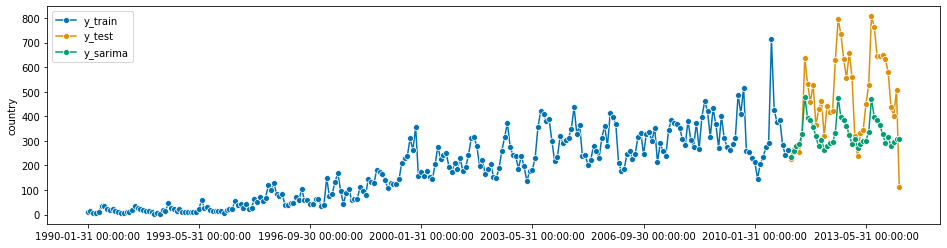

In [427]:
plot_series(y_train, y_test, y_sarima, labels = ['y_train', 'y_test', 'y_sarima']);

In [428]:
round(mse(y_test, y_sarima, squared = False),0)

203.0